# Modeling Hot Water Energy

### Select the parameters for the experiment and log in the experiment folder

In [30]:
# %%writefile param_sets.json
seed_value = 123  # seed for the experiment
Trial = 4  # number of the experiment

period = 3  # the period to sample the data at. 1 period= 5 minutes

inputcols = ['oat', 'orh', 'sat-oat', 'ghi', 'hw_sf', 'hx_vlv1']  # input predictors
x_loc = [4,5]  # vars we want to plot in detailed plot
outputcols = ['hwe']  # output targets
input_timesteps = 1  # number of timesteps for the input sequence
output_timesteps = 1  # number of timesteps for the output sequence

# Smoothing
smooth_data = False  # whetter to smooth the data or not
order = 5  # order of the filer
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

# adjust out of phase data
adjust_lag = True  # whether to adjust the lag for certain columns
lag_columns = outputcols  # choose columns to adjust lag
data_lag = -1  # lag by how many periods: negative means shift column upwards

# aggregate data based on period
aggregate_data = True  # aggregate data or not
rolling_sum_target = ['hwe', 'hw_sf']  # create sum aggregate for these columns
rolling_mean_target = [
    'hw_st', 'hw_rt', 'oat', 'sat-oat', 'sat', 'orh', 'ghi', 'avg_stpt','hx_vlv1',
]  # create mean aggregate for these columns

# create temporal batches of data: df2dflist
days, hours = 7, 0

#threshold: lower bound below which we ignore the row data(needed for removing hybrid system)
threshold = 2

# Custom way to create Training Data
data_weeks = 2  # shoudlbe greater than 1. Create a large initial block of training and testing data
create_lag = 0  # Create further lags in the output
scaling = True  # Scale the input and output features
feature_range = (0, 1)  # Scaling range
reshaping = True  # reshape data according to (batch_size, time_steps, features)

# model configuration
modelconfig = {
    'lstm_hidden_units': 8,
    'lstm_no_layers': 1,
    'dense_hidden_units': 8,
    'dense_no_layers': 4,
    'retrain_from_layers': 0,
    'stateful': False,
    'train_batchsize':32,
    'test_batchsize':1, # we are doing online prediction
    'train_epochs': 5000,
}

# wheter doing adaptive for fixed learning
adaptive_control = True  # whether we relearn or keep it fixed
path = '../results/' + outputcols[0] + '_model{}/'.format(
    Trial) + 'adaptive/' * adaptive_control + 'fixed/' * (1 - adaptive_control)
#!rm -rf ../results/lstm_hwe_trial8/adaptive

#model design considerations
modeldesigndone = False  # whether model will be reinitialized
initial_epoch = 0  # the start epoch number for the training

# These are automatically superseded and ignored if adaptive_control is set to False
retain_prev_model = True  # retain weights of model from previous training
freeze_model = False  # freeze weights of certain layers
reinitialize = False  # reinitialize the weights of certain layers
model_saved = False  # whether model has been saved once
test_model_created = False  # create an idectical model for online predicton

# data used for learning the model
datapath = '../data/processed/FebAprSept19BuildOcc.pkl'

# additional info
addl = {
    'metainfo': 'create a diff of sat and oat for hot water energy prediction as it is useful. See 1.0.8',
    'names_abreviation': {
        'oat':'Outside Air Temperature',
        'orh':'Outside Air Relative Humidity',
        'sat-oat' : 'Difference of Supply Air and Outside Air Temps ',
        'ghi': 'Global Solar Irradiance',
        'hw_sf':'Hot Water System Flow Rate',
        'hx_vlv1':'Hot Water Valve %',
        'hw_st':'Hot Water Supply Temperature',
        'fraction_occupied':'Percentage of building with occupancy sensor recording as occupied'
    }
}
x_lab = [addl['names_abreviation'][inputcols[i]] for i in x_loc]

### Set Seed in numpy, Keras and TF for reproducability
### Import modules
### Set GPU configurations

In [2]:
import shutil
import glob
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [5]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

### Create Folder to save models and tensorboard logs

In [4]:
# create the results directory
try:
    os.makedirs(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        try:
            shutil.rmtree(path + f)
        except NotADirectoryError:
            os.remove(path + f)
        
os.mkdir(path + 'loginfo')
os.mkdir(path + 'normalplots')
os.mkdir(path + 'detailedplots')

### Save the experiment parameters and configurations

In [5]:
#save the values
paramsdict = {
    
    'seed_value' : seed_value,
    
    'period':period,
    
    'inputcols':inputcols,
    'x_loc': x_loc,
    'outputcols':outputcols,
    'input_timesteps':input_timesteps,
    'output_timesteps':output_timesteps,
    
    'smooth_data': smooth_data,
    'order' : 5,
    'T' : T,
    'fs' : fs,
    'cutoff' : cutoff,
    
    'adjust_lag' : adjust_lag,
    'lag_columns' : lag_columns,
    'data_lag' : data_lag,
    
    'aggregate_data' : aggregate_data,
    'rolling_sum_target' : rolling_sum_target,
    'rolling_mean_target' : rolling_mean_target,
    
    'days':days,
    'hours':hours,
    
    'threshold': threshold,
    
    'data_weeks' : data_weeks,
    'create_lag' : create_lag,
    'scaling' : scaling,
    'feature_range' : feature_range,
    'reshaping' : reshaping,
    
    'modelconfig' : modelconfig,
    
    'adaptive_control':adaptive_control,
    'path':path,
    
    'modeldesigndone' : modeldesigndone,
    'initial_epoch' : initial_epoch,
    
    'retain_prev_model' : retain_prev_model,
    'freeze_model' : freeze_model,
    'reinitialize' : reinitialize,
    'model_saved' : model_saved,
    'test_model_created': test_model_created,
    
    'datapath' : datapath,
    
    'addl' : addl,
}
    
# with open(path+'params.json', 'r') as fp:
#     param2dict = json.load(fp)

with open(path+'params.json', 'w') as fp:
    json.dump(paramsdict, fp, indent=4)

### Read the cleaned data

In [6]:
# read the pickled file for ahu data
dfdata = dp.readfile(datapath)

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

### Create additional Data columns as needed

In [7]:
df['sat-oat']= df['sat']-df['oat']

# show data
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,hx_vlv1,fraction_occupied,sat-oat
2019-02-01 21:35:00,54.046474,57.620510,41.619118,0.0,0.0,0.0,73.057143,26.816679,0.0,98.046997,90.509659,0.0,0.935186,3.574036
2019-02-01 21:40:00,54.046474,57.620510,41.936150,0.0,0.0,0.0,73.057143,26.929094,0.0,98.046997,90.509659,0.0,0.935186,3.574036
2019-02-01 21:45:00,54.046474,57.620510,41.936150,0.0,0.0,0.0,73.057143,25.515333,0.0,97.748016,90.509659,0.0,0.935186,3.574036
2019-02-01 21:50:00,54.046474,57.620510,42.087753,0.0,0.0,0.0,73.057143,23.484247,0.0,97.748016,90.509659,0.0,0.935186,3.574036
2019-02-01 21:55:00,54.046474,57.920158,42.087753,0.0,0.0,0.0,73.057143,19.965048,0.0,97.748016,90.509659,0.0,0.935186,3.873684


### Smooth the data

In [8]:
if smooth_data:
    df = dp.dfsmoothing(df=df,
                        column_names=list(df.columns),
                        order=order,
                        Wn=cutoff,
                        T=T)

### Adjust lag for certain columns if needed

In [9]:
if adjust_lag:
    df = dp.createlag(df, lag_columns, lag=data_lag)

### Create aggregate data: aggregate specified columns at specified intervals

In [10]:
# return a new column which is the sum of previous window_size values
def window_sum(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).sum()

# return a new column which is the average of previous window_size values
def window_mean(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).mean()

# rolling_sum_output = ['{}min_{}_sum'.format(5*period,target) for target in rolling_sum_target]
# rolling_mean_output = ['{}min_{}_mean'.format(5*period,target) for target in rolling_mean_target]

if aggregate_data:
    
    # rolling sum
    df[rolling_sum_target] =  window_sum(df, window_size=period, column_names=rolling_sum_target)
    
    # rolling mean
    df[rolling_mean_target] =  window_mean(df, window_size=period, column_names=rolling_mean_target)
    
    df = dp.dropNaNrows(df)
    
    # Sample the data at period intervals
    df = dp.sample_timeseries_df(df, period=period)

### Create temporal chunks of data

In [11]:
df = df[(df['hw_sf']>=0.5) &
          (df['hx_vlv1']>=0.5) &
         (df['hwe']>=0.5)]

In [12]:
df.describe()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,hx_vlv1,fraction_occupied,sat-oat
count,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000,3542.000000
mean,64.065101,71.546388,59.218625,13.123188,24.694347,294.357708,71.597398,45.648961,33.309563,99.886415,89.600884,33.356810,0.843372,7.481287
std,15.975203,3.300395,17.153863,9.625050,16.319716,310.535578,1.153000,32.449558,22.604057,13.081843,12.785030,14.519830,0.102802,17.920604
min,26.579343,54.329060,24.501600,0.527934,0.000000,0.000000,66.238095,0.000234,1.012088,79.381727,73.102318,2.044991,0.111111,-22.015900
25%,49.419006,69.094900,46.816357,6.404958,10.886595,0.000000,70.638095,15.549512,14.443082,90.032059,79.580059,22.811579,0.777778,-6.436399
50%,66.665343,71.437467,58.223715,9.487983,25.630424,162.333333,71.390476,43.645073,35.941293,92.492691,84.894430,34.602036,0.824075,3.056653
75%,75.840057,74.419595,74.840472,18.704578,37.088410,577.666667,72.885714,71.539753,40.337518,111.178714,98.181760,45.594901,0.916667,26.123574
max,94.874298,80.316650,90.563845,70.939295,72.552849,961.000000,73.180952,128.265732,91.611572,138.360367,126.295802,71.694511,0.981482,47.974127


In [13]:
# Creating a list of "days" day dataframes for training
dflist = dp.df2dflist_alt(df[inputcols+outputcols],
                      subsequence=True,
                      period=period,
                      days=days,
                      hours=hours)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 13


### Custom way to create Training Data

In [14]:
# Since we are training across time, we need to ensure the input and output time steps are now 1
# otherwise the rearrangment of the data for batch speedup will be violated
assert (input_timesteps == 1) & (
    output_timesteps == 1), "Input and Output timesteps must be 1 for this notebook"

#### Create placeholder and functions

In [15]:
from pandas import concat, Timedelta


def quickmerge(listdf):
    return concat(listdf)


def df_list_reshape(datablock_df):
    new_df_list = []
    for i in range(int(10080 / (5 * period))):
        new_df_list.append(
            datablock_df[(datablock_df.index - datablock_df.index[i]) %
                         Timedelta('7 days') == '0 days 00:00:00'])
    return new_df_list

weeklist = []  # create list of training, testing arrays

#### Initial Data Block for offline training: select n weeks of data and extract continuous batches of size a least greater than LSTM training batch size and train on thise batches

In [16]:
# select and merge data_weeks-1 worth of data
datablock_train_pre = dflist[0:data_weeks-1]
datablock_train = quickmerge(datablock_train_pre)
#divide into non-zero operating region
datablock_train = dp.subsequencing(datablock_train, period=period)
#drop smaller blocks
datablock_train = [item for item in datablock_train if item.shape[0] >= 0.05*modelconfig['train_batchsize']]
#merge them together
minibatch_train = quickmerge(datablock_train)

# select weeks=1 worth of data
datablock_test_pre = dflist[data_weeks-1]
#divide into non-zero operating region
datablock_test = dp.subsequencing(datablock_test_pre, period=period)
#drop smaller blocks
datablock_test = [item for item in datablock_test if item.shape[0] >= 0.05*modelconfig['test_batchsize']]
#merge them together
minibatch_test = quickmerge(datablock_test)


# splitvalue
splitvalue = minibatch_test.shape[0]
#merge test and train together
data_block = quickmerge([minibatch_train, minibatch_test])

# create numpy arrays
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

# select test ids for later plots
test_idx = minibatch_test.index

# append them
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(minibatch_test.index[int(splitvalue/2)].year), 
                                      str(minibatch_test.index[int(splitvalue/2)].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })


#### Create small blocks of data for weekly training

In [17]:
for weekdata in dflist[data_weeks:]:
    
    # select and merge data_weeks-1 worth of data
    datablock_train_pre = datablock_train_pre[1:]+[datablock_test_pre]
    datablock_train = quickmerge(datablock_train_pre)
    #divide into non-zero operating region
    datablock_train = dp.subsequencing(datablock_train, period=period)
    #drop smaller blocks
    datablock_train = [item for item in datablock_train if item.shape[0] >= 0.05*modelconfig['train_batchsize']]
    #merge them together
    minibatch_train = quickmerge(datablock_train)
    
    # select weeks=1 worth of data
    datablock_test_pre = weekdata
    #divide into non-zero operating region
    datablock_test = dp.subsequencing(datablock_test_pre, period=period)
    #drop smaller blocks
    datablock_test = [item for item in datablock_test if item.shape[0] >= 0.05*modelconfig['test_batchsize']]
    #merge them together
    minibatch_test = quickmerge(datablock_test)
    
    # splitvalue
    splitvalue = minibatch_test.shape[0]
    #merge test and train together
    data_block = quickmerge([minibatch_train, minibatch_test])

    # and add new week data from weekdata
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

    # select test ids for later plots
    test_idx = minibatch_test.index

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(minibatch_test.index[int(splitvalue/2)].year), 
                                      str(minibatch_test.index[int(splitvalue/2)].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 12


#### Print size and shape of data to feed to the LSTM for sanity checks

In [18]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            print("name: {}, shape: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, shape: Year-2019-Week-7
name: X_train, shape: (295, 1, 6)
name: y_train, shape: (295, 1, 1)
name: X_test, shape: (170, 1, 6)
name: y_test, shape: (170, 1, 1)
name: test_idx, shape: (170,)
name: Id, shape: Year-2019-Week-8
name: X_train, shape: (162, 1, 6)
name: y_train, shape: (162, 1, 1)
name: X_test, shape: (420, 1, 6)
name: y_test, shape: (420, 1, 1)
name: test_idx, shape: (420,)
name: Id, shape: Year-2019-Week-9
name: X_train, shape: (419, 1, 6)
name: y_train, shape: (419, 1, 1)
name: X_test, shape: (261, 1, 6)
name: y_test, shape: (261, 1, 1)
name: test_idx, shape: (261,)
name: Id, shape: Year-2019-Week-14
name: X_train, shape: (260, 1, 6)
name: y_train, shape: (260, 1, 1)
name: X_test, shape: (142, 1, 6)
name: y_test, shape: (142, 1, 1)
name: test_idx, shape: (142,)
name: Id, shape: Year-2019-Week-15
name: X_train, shape: (141, 1, 6)
name: y_train, shape: (141, 1, 1)
name: X_test, shape: (325, 1, 6)
name: y_test, shape: (325, 1, 1)
name: test_idx, shape: (325,)
name: Id

#### Add weekly train test data to modelconfig dictionary for ease of training

In [19]:
modelconfig['weeklist'] = weeklist

###  Clear the Tensorflow graph from previous training

In [20]:
try:
    del nn_model
except NameError:
    pass

K.clear_session()

### Inspect model architecture

In [ ]:
# weekdata = modelconfig['weeklist'][0]
# X_train = weekdata['X_train']
# y_train = weekdata['y_train']
# X_test = weekdata['X_test']
# y_test = weekdata['y_test']
# y_scaler = weekdata['y_scaler']

# #Instantiate learner model
# nn_model = mp.seq2seq_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()

# nn_model.model.summary()

### Perform relearning on chunks of temporal data

In [21]:
for weekno, BatchData in enumerate(tqdm(modelconfig['weeklist'])):

    """Begin weekly training"""   
    X_train = BatchData['X_train']
    y_train = BatchData['y_train']

    try:
        del nn_model
    except NameError:
        pass

    K.clear_session()

    #Instantiate learner model
    nn_model = mp.simple_LSTM_model(path,
                                  inputdim=X_train.shape[-1],
                                  outputdim=y_train.shape[-1],
                                  input_timesteps=input_timesteps,
                                  output_timesteps = output_timesteps,
                                  period=period,
                                  stateful = modelconfig['stateful'],
                                  batch_size=modelconfig['train_batchsize'])

    # Desing model architecture
    nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])

    # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
    if model_saved & retain_prev_model:
        nn_model.model.load_weights('IntermediateModel.h5')


    # compile model
    nn_model.model_compile()   

    # train the model for adaptive model and fixed after first round for fixed control
    if adaptive_control | (weekno==0):
        history = nn_model.train_model(X_train,
                                       y_train,
                                       epochs=modelconfig['train_epochs'],
                                       initial_epoch=initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # save the model only if trained at least once- needed for prediction model
        nn_model.model.save('IntermediateModel.h5')
        model_saved = True     
    """End Weekly Training"""
    
    
    """Begin Last Week Prediction"""
    
    y_scaler = BatchData['y_scaler']
    X_scaler = BatchData['X_scaler']
    X_test = BatchData['X_test']
    y_test = BatchData['y_test']
   
    try:
        del nn_model_pred
    except NameError:
        pass
    K.clear_session()

    # Separate predictor for predicting online: only difference is test batch size
    nn_model_pred = mp.simple_LSTM_model(path,
                                       inputdim=X_test.shape[-1],
                                       outputdim=y_test.shape[-1],
                                       input_timesteps=input_timesteps,
                                       output_timesteps = output_timesteps,
                                       period=period,
                                       stateful = modelconfig['stateful'],
                                       batch_size=modelconfig['test_batchsize'])

    # Desing model architecture
    nn_model_pred.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])


    # load the trained model weights
    nn_model_pred.model.load_weights('IntermediateModel.h5')
    # compile model
    nn_model_pred.model_compile()

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    preds_test = nn_model_pred.evaluate_model( X_test,
                                               y_test,
                                               y_scaler,
                                               save_plot_loc=path+'normalplots/',
                                               scaling=True,
                                               saveplot=True,
                                               Idx=BatchData['Id'],
                                               outputdim_names=outputcols)

    # do a detailed plot instead
    pu.detailedplot(period * 5,
                    xs = date2num(list(BatchData['test_idx'])),
                    outputdim=len(outputcols),
                    output_timesteps=output_timesteps,
                    input_timesteps=input_timesteps,
                    pred=preds_test,
                    target=y_test,
                    X_var=X_test,
                    x_loc=x_loc,
                    x_lab=x_lab,
                    saveloc=path + 'detailedplots/',
                    scaling=True,
                    Xscaler=X_scaler,
                    yscaler=y_scaler,
                    typeofplot='test',
                    Idx=BatchData['Id'])
    """End Last Week Prediction"""

    """Only execute when we are freezing LSTM and just training on Dense"""
    if adaptive_control:
        
        # freeze all but dense layers at the top and compile with new weights
        if freeze_model:
            for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
                layer.trainable = False

        # for relearning, reinitialize top few layers
        if reinitialize:
            for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
                layer.kernel.initializer.run(session=K.get_session())
                layer.bias.initializer.run(session=K.get_session())

        # recompile model
        if freeze_model | reinitialize:
            nn_model.model_compile()
            
            # save the model- needed for Keras limitations: Tensorboard crashes if we relearn on original model with
            # reinitialized weights; solution: we create new model and load these weights
            nn_model.model.save('IntermediateModel.h5')
            model_saved = True
            
            freeze_model = False
            reinitialize = False

  0%|          | 0/12 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5000
 - 0s - loss: 0.0327
Epoch 2/5000
 - 0s - loss: 0.0204
Epoch 3/5000
 - 0s - loss: 0.0141
Epoch 4/5000
 - 0s - loss: 0.0111
Epoch 5/5000
 - 0s - loss: 0.0100
Epoch 6/5000
 - 0s - loss: 0.0099
Epoch 7/5000
 - 0s - loss: 0.0097
Epoch 8/5000
 - 0s - loss: 0.0094
Epoch 9/5000
 - 0s - loss: 0.0091
Epoch 10/5000
 - 0s - loss: 0.0089
Epoch 11/5000
 - 0s - loss: 0.0088
Epoch 12/5000
 - 0s - loss: 0.0088
Epoch 13/5000
 - 0s - loss: 0.0087
Epoch 14/5000
 - 0s - loss: 0.0087
Epoch 15/5000
 - 0s - loss: 0.0087
Epoch 16/5000
 - 0s - loss: 0.0085
Epoch 17/5000
 - 0s - loss: 0.0085
Epoch 18/5000
 - 0s - loss: 0.0085
Epoch 19/5000
 - 0s - loss: 0.0085
Epoch 20/5000
 - 0s - loss: 0.0085
Epoch 21/5000
 - 0s - loss: 0.0085
Epoch 22/5000
 - 0s - loss: 0.0085
Epoch 23/5000
 - 0s - loss: 0.0085
Epoch 24/5000
 - 0s - loss: 0.0085
Epoch 25/5000
 - 0s - loss: 0.0085
Epoch 26/5000
 - 0s - loss: 0.0085


  8%|▊         | 1/12 [00:06<01:13,  6.66s/it]

Epoch 42/5000
 - 0s - loss: 0.0378
Epoch 43/5000
 - 0s - loss: 0.0292
Epoch 44/5000
 - 0s - loss: 0.0244
Epoch 45/5000
 - 0s - loss: 0.0226
Epoch 46/5000
 - 0s - loss: 0.0226
Epoch 47/5000
 - 0s - loss: 0.0233
Epoch 48/5000
 - 0s - loss: 0.0237
Epoch 49/5000
 - 0s - loss: 0.0237
Epoch 50/5000
 - 0s - loss: 0.0237


 17%|█▋        | 2/12 [00:10<00:57,  5.71s/it]

Epoch 51/5000
 - 0s - loss: 0.0286
Epoch 52/5000
 - 0s - loss: 0.0232
Epoch 53/5000
 - 0s - loss: 0.0215
Epoch 54/5000
 - 0s - loss: 0.0202
Epoch 55/5000
 - 0s - loss: 0.0191
Epoch 56/5000
 - 0s - loss: 0.0185
Epoch 57/5000
 - 0s - loss: 0.0181
Epoch 58/5000
 - 0s - loss: 0.0176
Epoch 59/5000
 - 0s - loss: 0.0172
Epoch 60/5000
 - 0s - loss: 0.0167
Epoch 61/5000
 - 0s - loss: 0.0162
Epoch 62/5000
 - 0s - loss: 0.0157
Epoch 63/5000
 - 0s - loss: 0.0152
Epoch 64/5000
 - 0s - loss: 0.0147
Epoch 65/5000
 - 0s - loss: 0.0142
Epoch 66/5000
 - 0s - loss: 0.0138
Epoch 67/5000
 - 0s - loss: 0.0135
Epoch 68/5000
 - 0s - loss: 0.0132
Epoch 69/5000
 - 0s - loss: 0.0130
Epoch 70/5000
 - 0s - loss: 0.0127
Epoch 71/5000
 - 0s - loss: 0.0125
Epoch 72/5000
 - 0s - loss: 0.0123
Epoch 73/5000
 - 0s - loss: 0.0120
Epoch 74/5000
 - 0s - loss: 0.0118
Epoch 75/5000
 - 0s - loss: 0.0116
Epoch 76/5000
 - 0s - loss: 0.0114
Epoch 77/5000
 - 0s - loss: 0.0112
Epoch 78/5000
 - 0s - loss: 0.0110
Epoch 79/5000
 - 0s 

 25%|██▌       | 3/12 [00:20<01:04,  7.21s/it]

Epoch 133/5000
 - 0s - loss: 0.0118
Epoch 134/5000
 - 0s - loss: 0.0090
Epoch 135/5000
 - 0s - loss: 0.0088
Epoch 136/5000
 - 0s - loss: 0.0082
Epoch 137/5000
 - 0s - loss: 0.0079
Epoch 138/5000
 - 0s - loss: 0.0078
Epoch 139/5000
 - 0s - loss: 0.0075
Epoch 140/5000
 - 0s - loss: 0.0072
Epoch 141/5000
 - 0s - loss: 0.0070
Epoch 142/5000
 - 0s - loss: 0.0068
Epoch 143/5000
 - 0s - loss: 0.0067
Epoch 144/5000
 - 0s - loss: 0.0065
Epoch 145/5000
 - 0s - loss: 0.0063
Epoch 146/5000
 - 0s - loss: 0.0062
Epoch 147/5000
 - 0s - loss: 0.0061
Epoch 148/5000
 - 0s - loss: 0.0060
Epoch 149/5000
 - 0s - loss: 0.0059
Epoch 150/5000
 - 0s - loss: 0.0058
Epoch 151/5000
 - 0s - loss: 0.0057
Epoch 152/5000
 - 0s - loss: 0.0056
Epoch 153/5000
 - 0s - loss: 0.0055
Epoch 154/5000
 - 0s - loss: 0.0054
Epoch 155/5000
 - 0s - loss: 0.0054
Epoch 156/5000
 - 0s - loss: 0.0053
Epoch 157/5000
 - 0s - loss: 0.0052
Epoch 158/5000
 - 0s - loss: 0.0051
Epoch 159/5000
 - 0s - loss: 0.0051
Epoch 160/5000
 - 0s - loss:

 33%|███▎      | 4/12 [00:28<00:57,  7.21s/it]

Epoch 194/5000
 - 0s - loss: 0.0172
Epoch 195/5000
 - 0s - loss: 0.0097
Epoch 196/5000
 - 0s - loss: 0.0101
Epoch 197/5000
 - 0s - loss: 0.0099
Epoch 198/5000
 - 0s - loss: 0.0086
Epoch 199/5000
 - 0s - loss: 0.0085
Epoch 200/5000
 - 0s - loss: 0.0084
Epoch 201/5000
 - 0s - loss: 0.0083
Epoch 202/5000
 - 0s - loss: 0.0082
Epoch 203/5000
 - 0s - loss: 0.0081
Epoch 204/5000
 - 0s - loss: 0.0080
Epoch 205/5000
 - 0s - loss: 0.0079
Epoch 206/5000
 - 0s - loss: 0.0078
Epoch 207/5000
 - 0s - loss: 0.0077
Epoch 208/5000
 - 0s - loss: 0.0077
Epoch 209/5000
 - 0s - loss: 0.0076
Epoch 210/5000
 - 0s - loss: 0.0075
Epoch 211/5000
 - 0s - loss: 0.0075
Epoch 212/5000
 - 0s - loss: 0.0074
Epoch 213/5000
 - 0s - loss: 0.0073
Epoch 214/5000
 - 0s - loss: 0.0073
Epoch 215/5000
 - 0s - loss: 0.0072
Epoch 216/5000
 - 0s - loss: 0.0072
Epoch 217/5000
 - 0s - loss: 0.0071
Epoch 218/5000
 - 0s - loss: 0.0071
Epoch 219/5000
 - 0s - loss: 0.0070
Epoch 220/5000
 - 0s - loss: 0.0070
Epoch 221/5000
 - 0s - loss:

 42%|████▏     | 5/12 [00:33<00:47,  6.75s/it]

Epoch 243/5000
 - 0s - loss: 0.0057
Epoch 244/5000
 - 0s - loss: 0.0022
Epoch 245/5000
 - 0s - loss: 0.0020
Epoch 246/5000
 - 0s - loss: 0.0019
Epoch 247/5000
 - 0s - loss: 0.0017
Epoch 248/5000
 - 0s - loss: 0.0016
Epoch 249/5000
 - 0s - loss: 0.0015
Epoch 250/5000
 - 0s - loss: 0.0015
Epoch 251/5000
 - 0s - loss: 0.0014
Epoch 252/5000
 - 0s - loss: 0.0014
Epoch 253/5000
 - 0s - loss: 0.0013
Epoch 254/5000
 - 0s - loss: 0.0012
Epoch 255/5000
 - 0s - loss: 0.0012
Epoch 256/5000
 - 0s - loss: 0.0012
Epoch 257/5000
 - 0s - loss: 0.0012
Epoch 258/5000
 - 0s - loss: 0.0012
Epoch 259/5000
 - 0s - loss: 0.0012
Epoch 260/5000
 - 0s - loss: 0.0012
Epoch 261/5000
 - 0s - loss: 0.0012
Epoch 262/5000
 - 0s - loss: 0.0012
Epoch 263/5000
 - 0s - loss: 0.0012
Epoch 264/5000
 - 0s - loss: 0.0012
Epoch 265/5000
 - 0s - loss: 0.0012
Epoch 266/5000
 - 0s - loss: 0.0012
Epoch 267/5000
 - 0s - loss: 0.0012
Epoch 268/5000
 - 0s - loss: 0.0012
Epoch 269/5000
 - 0s - loss: 0.0012
Epoch 270/5000
 - 0s - loss:

 50%|█████     | 6/12 [00:39<00:39,  6.55s/it]

Epoch 280/5000
 - 0s - loss: 0.0093
Epoch 281/5000
 - 0s - loss: 0.0062
Epoch 282/5000
 - 0s - loss: 0.0069
Epoch 283/5000
 - 0s - loss: 0.0063
Epoch 284/5000
 - 0s - loss: 0.0056
Epoch 285/5000
 - 0s - loss: 0.0056
Epoch 286/5000
 - 0s - loss: 0.0055
Epoch 287/5000
 - 0s - loss: 0.0055
Epoch 288/5000
 - 0s - loss: 0.0055
Epoch 289/5000
 - 0s - loss: 0.0055
Epoch 290/5000
 - 0s - loss: 0.0055
Epoch 291/5000
 - 0s - loss: 0.0055
Epoch 292/5000
 - 0s - loss: 0.0055
Epoch 293/5000
 - 0s - loss: 0.0055
Epoch 294/5000
 - 0s - loss: 0.0055
Epoch 295/5000
 - 0s - loss: 0.0055
Epoch 296/5000
 - 0s - loss: 0.0055
Epoch 297/5000
 - 0s - loss: 0.0055
Epoch 298/5000
 - 0s - loss: 0.0055
Epoch 299/5000
 - 0s - loss: 0.0055
Epoch 300/5000
 - 0s - loss: 0.0055
Epoch 301/5000
 - 0s - loss: 0.0055
Epoch 302/5000
 - 0s - loss: 0.0055
Epoch 303/5000
 - 0s - loss: 0.0055
Epoch 304/5000
 - 0s - loss: 0.0055
Epoch 305/5000
 - 0s - loss: 0.0055
Epoch 306/5000
 - 0s - loss: 0.0055
Epoch 307/5000
 - 0s - loss:

 58%|█████▊    | 7/12 [00:45<00:30,  6.17s/it]

Epoch 314/5000
 - 0s - loss: 0.0156
Epoch 315/5000
 - 0s - loss: 0.0073
Epoch 316/5000
 - 0s - loss: 0.0057
Epoch 317/5000
 - 0s - loss: 0.0046
Epoch 318/5000
 - 0s - loss: 0.0037
Epoch 319/5000
 - 0s - loss: 0.0035
Epoch 320/5000
 - 0s - loss: 0.0035
Epoch 321/5000
 - 0s - loss: 0.0033
Epoch 322/5000
 - 0s - loss: 0.0033
Epoch 323/5000
 - 0s - loss: 0.0032
Epoch 324/5000
 - 0s - loss: 0.0031
Epoch 325/5000
 - 0s - loss: 0.0030
Epoch 326/5000
 - 0s - loss: 0.0029
Epoch 327/5000
 - 0s - loss: 0.0029
Epoch 328/5000
 - 0s - loss: 0.0028
Epoch 329/5000
 - 0s - loss: 0.0028
Epoch 330/5000
 - 0s - loss: 0.0027
Epoch 331/5000
 - 0s - loss: 0.0027
Epoch 332/5000
 - 0s - loss: 0.0027
Epoch 333/5000
 - 0s - loss: 0.0027
Epoch 334/5000
 - 0s - loss: 0.0027
Epoch 335/5000
 - 0s - loss: 0.0027
Epoch 336/5000
 - 0s - loss: 0.0027
Epoch 337/5000
 - 0s - loss: 0.0027
Epoch 338/5000
 - 0s - loss: 0.0027
Epoch 339/5000
 - 0s - loss: 0.0027
Epoch 340/5000
 - 0s - loss: 0.0027
Epoch 341/5000
 - 0s - loss:

 67%|██████▋   | 8/12 [00:51<00:24,  6.18s/it]

Epoch 358/5000
 - 0s - loss: 0.0104
Epoch 359/5000
 - 0s - loss: 0.0084
Epoch 360/5000
 - 0s - loss: 0.0067
Epoch 361/5000
 - 0s - loss: 0.0066
Epoch 362/5000
 - 0s - loss: 0.0063
Epoch 363/5000
 - 0s - loss: 0.0059
Epoch 364/5000
 - 0s - loss: 0.0056
Epoch 365/5000
 - 0s - loss: 0.0054
Epoch 366/5000
 - 0s - loss: 0.0053
Epoch 367/5000
 - 0s - loss: 0.0051
Epoch 368/5000
 - 0s - loss: 0.0050
Epoch 369/5000
 - 0s - loss: 0.0048
Epoch 370/5000
 - 0s - loss: 0.0047
Epoch 371/5000
 - 0s - loss: 0.0046
Epoch 372/5000
 - 0s - loss: 0.0045
Epoch 373/5000
 - 0s - loss: 0.0044
Epoch 374/5000
 - 0s - loss: 0.0044
Epoch 375/5000
 - 0s - loss: 0.0043
Epoch 376/5000
 - 0s - loss: 0.0042
Epoch 377/5000
 - 0s - loss: 0.0042
Epoch 378/5000
 - 0s - loss: 0.0041
Epoch 379/5000
 - 0s - loss: 0.0041
Epoch 380/5000
 - 0s - loss: 0.0040
Epoch 381/5000
 - 0s - loss: 0.0039
Epoch 382/5000
 - 0s - loss: 0.0039
Epoch 383/5000
 - 0s - loss: 0.0038
Epoch 384/5000
 - 0s - loss: 0.0038
Epoch 385/5000
 - 0s - loss:

 75%|███████▌  | 9/12 [00:57<00:18,  6.10s/it]

Epoch 414/5000
 - 0s - loss: 0.0833
Epoch 415/5000
 - 0s - loss: 0.0434
Epoch 416/5000
 - 0s - loss: 0.0304
Epoch 417/5000
 - 0s - loss: 0.0202
Epoch 418/5000
 - 0s - loss: 0.0164
Epoch 419/5000
 - 0s - loss: 0.0144
Epoch 420/5000
 - 0s - loss: 0.0133
Epoch 421/5000
 - 0s - loss: 0.0123
Epoch 422/5000
 - 0s - loss: 0.0117
Epoch 423/5000
 - 0s - loss: 0.0113
Epoch 424/5000
 - 0s - loss: 0.0110
Epoch 425/5000
 - 0s - loss: 0.0108
Epoch 426/5000
 - 0s - loss: 0.0107
Epoch 427/5000
 - 0s - loss: 0.0106
Epoch 428/5000
 - 0s - loss: 0.0105
Epoch 429/5000
 - 0s - loss: 0.0104
Epoch 430/5000
 - 0s - loss: 0.0103
Epoch 431/5000
 - 0s - loss: 0.0102
Epoch 432/5000
 - 0s - loss: 0.0101
Epoch 433/5000
 - 0s - loss: 0.0100
Epoch 434/5000
 - 0s - loss: 0.0099
Epoch 435/5000
 - 0s - loss: 0.0098
Epoch 436/5000
 - 0s - loss: 0.0097
Epoch 437/5000
 - 0s - loss: 0.0096
Epoch 438/5000
 - 0s - loss: 0.0095
Epoch 439/5000
 - 0s - loss: 0.0094
Epoch 440/5000
 - 0s - loss: 0.0093
Epoch 441/5000
 - 0s - loss:

 83%|████████▎ | 10/12 [01:05<00:13,  6.84s/it]

Epoch 490/5000
 - 0s - loss: 0.0274
Epoch 491/5000
 - 0s - loss: 0.0187
Epoch 492/5000
 - 0s - loss: 0.0203
Epoch 493/5000
 - 0s - loss: 0.0181
Epoch 494/5000
 - 0s - loss: 0.0160
Epoch 495/5000
 - 0s - loss: 0.0163
Epoch 496/5000
 - 0s - loss: 0.0158
Epoch 497/5000
 - 0s - loss: 0.0151
Epoch 498/5000
 - 0s - loss: 0.0152
Epoch 499/5000
 - 0s - loss: 0.0146
Epoch 500/5000
 - 0s - loss: 0.0145
Epoch 501/5000
 - 0s - loss: 0.0143
Epoch 502/5000
 - 0s - loss: 0.0140
Epoch 503/5000
 - 0s - loss: 0.0138
Epoch 504/5000
 - 0s - loss: 0.0135
Epoch 505/5000
 - 0s - loss: 0.0133
Epoch 506/5000
 - 0s - loss: 0.0130
Epoch 507/5000
 - 0s - loss: 0.0128
Epoch 508/5000
 - 0s - loss: 0.0126
Epoch 509/5000
 - 0s - loss: 0.0124
Epoch 510/5000
 - 0s - loss: 0.0122
Epoch 511/5000
 - 0s - loss: 0.0121
Epoch 512/5000
 - 0s - loss: 0.0119
Epoch 513/5000
 - 0s - loss: 0.0117
Epoch 514/5000
 - 0s - loss: 0.0116
Epoch 515/5000
 - 0s - loss: 0.0115
Epoch 516/5000
 - 0s - loss: 0.0113
Epoch 517/5000
 - 0s - loss:

 92%|█████████▏| 11/12 [01:14<00:07,  7.29s/it]

Epoch 555/5000
 - 0s - loss: 0.0087
Epoch 556/5000
 - 0s - loss: 0.0069
Epoch 557/5000
 - 0s - loss: 0.0058
Epoch 558/5000
 - 0s - loss: 0.0050
Epoch 559/5000
 - 0s - loss: 0.0047
Epoch 560/5000
 - 0s - loss: 0.0043
Epoch 561/5000
 - 0s - loss: 0.0042
Epoch 562/5000
 - 0s - loss: 0.0040
Epoch 563/5000
 - 0s - loss: 0.0039
Epoch 564/5000
 - 0s - loss: 0.0038
Epoch 565/5000
 - 0s - loss: 0.0037
Epoch 566/5000
 - 0s - loss: 0.0036
Epoch 567/5000
 - 0s - loss: 0.0034
Epoch 568/5000
 - 0s - loss: 0.0032
Epoch 569/5000
 - 0s - loss: 0.0031
Epoch 570/5000
 - 0s - loss: 0.0029
Epoch 571/5000
 - 0s - loss: 0.0027
Epoch 572/5000
 - 0s - loss: 0.0025
Epoch 573/5000
 - 0s - loss: 0.0024
Epoch 574/5000
 - 0s - loss: 0.0023
Epoch 575/5000
 - 0s - loss: 0.0023
Epoch 576/5000
 - 0s - loss: 0.0021
Epoch 577/5000
 - 0s - loss: 0.0020
Epoch 578/5000
 - 0s - loss: 0.0020
Epoch 579/5000
 - 0s - loss: 0.0020
Epoch 580/5000
 - 0s - loss: 0.0020
Epoch 581/5000
 - 0s - loss: 0.0020
Epoch 582/5000
 - 0s - loss:

100%|██████████| 12/12 [01:21<00:00,  6.76s/it]


### Plot the CVRMSE error on chunks of temporal data

Name of the file:  ../results/hwe_model4/adaptive/15min Results_File.txt


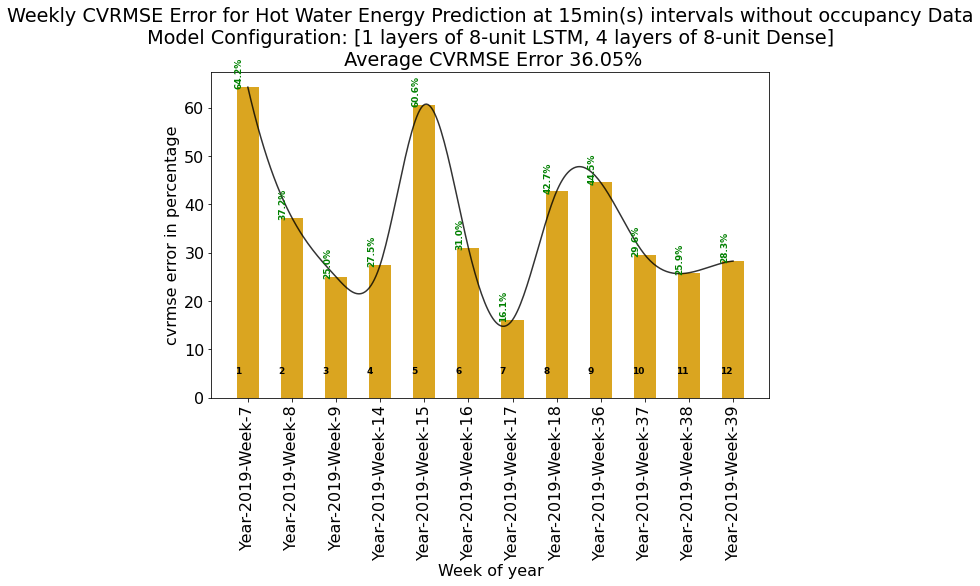

In [31]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Prediction at {5:}min(s) intervals without occupancy Data\n Model Configuration: [{0:} layers of {1:}-unit LSTM, {2:} layers of {3:}-unit Dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=6,
    fontsize=16)
pu.single_bar_plot(**plot_args)

### Merge the pdfs together

In [23]:
# path where files are stored
pdfs_loc = path + 'detailedplots/'
# list all the files
flist = sorted(
    glob.glob(os.path.join(pdfs_loc, '*'))
)

In [24]:
from PyPDF2 import PdfFileMerger, PdfFileReader
 
# Call the PdfFileMerger
mergedObject = PdfFileMerger()
 
# I had 116 files in the folder that had to be merged into a single document
# Loop through all of them and append their pages
for filename in flist:
    mergedObject.append(PdfFileReader(filename, 'rb'))
    
#  Write all the files into a file which is named as shown below
mergedObject.write(path+'DetailedPredvsTarget.pdf')

### Code cemetery

In [ ]:
# from keras.utils import plot_model
# plot_model(nn_model.model, to_file='model.png',show_shapes=True,)


# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)


#model.model.summary()


#nn_model.model.layers[-1].input_shape
#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())
#nn_model.model.layers[-1].output_shape